__SC24219070 朱越__

# 导入库与加载数据
程序结构参考了d2l的Softmax和CNN章节内容。

## 加载必要的库，然后使用torch中的工具加载数据集

In [1]:
import torch
from torch import nn
from torch.utils import data
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [2]:
#加载数据集，由于是预先下载好的，所以download使用False
trainset = CIFAR10(root='datas', train=True, download=False, transform=transforms.ToTensor())
testset = CIFAR10(root='datas', train=False, download=False, transform=transforms.ToTensor())
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

## 先打印一部分训练集看一下导入的情况

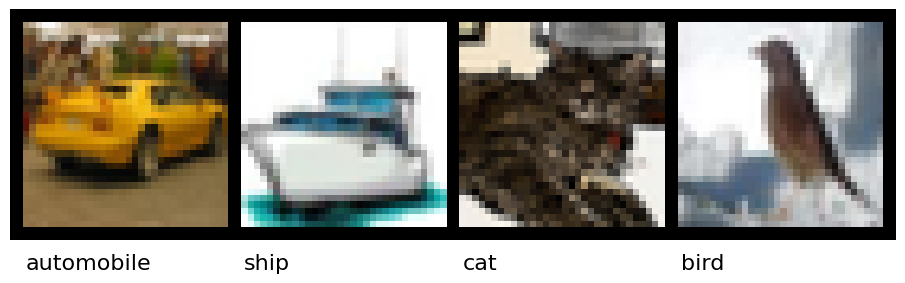

In [3]:
batch_size = 4
dataloader = data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
# 获取一个批次的数据
images, labels = next(iter(dataloader))
# 将Tensor转为网格并显示
grid = make_grid(images)  # 合并为网格图像
grid = grid.permute(1, 2, 0)  # 从 [C, H, W] 转为 [H, W, C] 供matplotlib显示
# 显示图像网格
plt.figure(figsize=(12,3))
plt.imshow(grid)
plt.axis('off')
# 在每个子图下方添加标签
for num, (label) in enumerate(labels):
    plt.text((num%batch_size)*(images.shape[2]+2)+2, (num//batch_size+1)*(images.shape[3]+4)+batch_size, 
             f"{classes[label.item()]}", color='black', fontsize=16)
plt.show()

可以看到图像和标签都是对应的（大概）

# 构建模型和定义变量
## 预先定义了训练时需要的参数初始化、分类正确率统计函数等
这里的函数都是借鉴d2l库的，不过在init上换用了别的策略。

In [4]:
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.kaiming_uniform_(m.weight)  
        #因为使用了ReLU激活，所以用He初始化更好

def accuracy(y_hat, y):
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

class Accumulator:
    """在n个变量上累加"""
    def __init__(self, num):
        self.data = [0.0] * num

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

## 定义了训练中用到的变量、定义了网络结构、损失函数和优化方法
由于算力实在有限，几次尝试训练后选择了比较激进的学习率和网络参数。

ds推荐了一些数据增强的方法，不过训练成本不支持我使用了:(

In [5]:
batch_size = 100
lr = 0.03  #由于硬件资源比较一般，所以使用了比较激进的lr，希望可以减少训练次数
num_epochs = 20  #经过几次训练发现，test_accuracy基本都在20次前稳定
#抽取数据
train_iter = data.DataLoader(trainset, batch_size, shuffle=True)
test_iter = data.DataLoader(testset, batch_size, shuffle=False)
#定义网络，采用了Alexnet的结构，但是根据CIFAR10数据集修改了参量
net = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=7, stride=1, padding=3), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(16, 64, kernel_size=5, stride=1, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(64, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(256, 64, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(64*4*4, 256), nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(256, 256), nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(256, 10)
)
#初始化网络、定义损失函数和优化方法
net.apply(init_weights)
loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr)

train_loss = torch.zeros(num_epochs)
train_acc = torch.zeros(num_epochs)
test_acc = torch.zeros(num_epochs)

# 开始炼！

In [6]:
for epoch in range(num_epochs):
    # 执行梯度下降
    net.train()  # 将模型设置为训练模式
    metric = Accumulator(3)  # 训练损失总和、训练准确度总和、样本数
    for x, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(x)
        l = loss(y_hat, y)
        trainer.zero_grad()
        l.mean().backward()
        trainer.step()
        # 训练损失和训练精度
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    train_loss[epoch], train_acc[epoch] = (metric[0] / metric[2], metric[1] / metric[2])        
    # 计算在指定数据集上模型的精度
    net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for x, y in test_iter:
            metric.add(accuracy(net(x), y), y.numel())
    test_acc[epoch] = metric[0] / metric[1]
    if((epoch+1)%5 == 0):
        print(f'epoch:{epoch+1}, train_loss:{train_loss[epoch]:.4f}, train_acc:{train_acc[epoch]:.4f}, test_acc:{test_acc[epoch]:.4f}')
#可以设置一些断言来评价训练结果，但是这里用处不大，故不使用
#assert train_loss[-1] < 0.5, train_loss
#assert 0.7 < train_acc[-1] <= 1, train_acc
#assert 0.7 < test_acc[-1] <= 1, test_acc

epoch:5, train_loss:1.2562, train_acc:0.5504, test_acc:0.5770
epoch:10, train_loss:0.8995, train_acc:0.6835, test_acc:0.6602
epoch:15, train_loss:0.6020, train_acc:0.7872, test_acc:0.6881
epoch:20, train_loss:0.3599, train_acc:0.8748, test_acc:0.6794


# 训练结果与后处理
## 网络损失和分类正确率的可视化
根据曲线可以看出，网络在10~15次训练后开始收敛。

后续的训练只有train_acc升高而test_acc不升高，表示开始进入过拟合。

因此更多的训练次数就没有更多的收益了。

而test_acc在增长的过程中并没有观察到过多的振荡，说明lr的设置也没有特别过分。

（之前尝试过0.05的，也没有振荡，只是test_acc只能达到50+就饱和了）

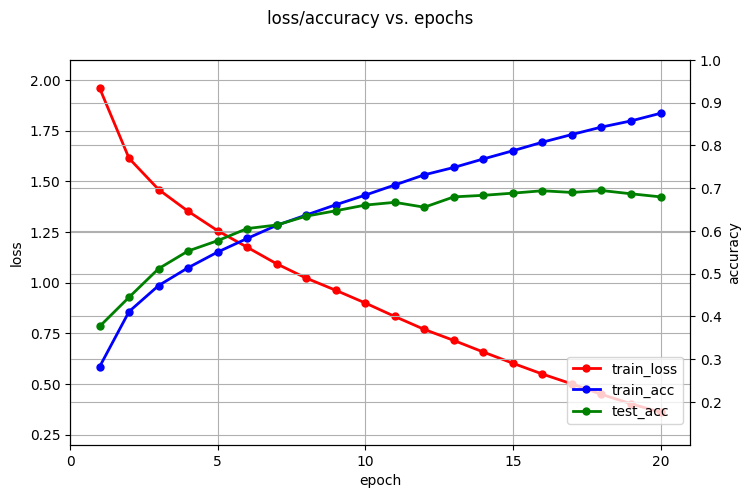

In [7]:
epochs = torch.arange(1, num_epochs+1)
# 创建图表和主y轴
fig, ax1 = plt.subplots(figsize=(8,5))
# 绘制第一个y轴的数据
ax1.grid()
ax1.plot(epochs, train_loss, label='train_loss', color='r', linestyle='-', marker='.', ms=10, mec='r', linewidth=2)
ax1.set_xlabel("epoch")
ax1.set_xlim(0, num_epochs+1)
ax1.set_xticks(torch.arange(0, num_epochs+1, 5))
ax1.set_ylabel("loss")
ax1.set_ylim(bottom=torch.floor(min(train_loss)*10)/10-0.1,
             top=torch.ceil(max(train_loss)*10)/10+0.1)  # 自动调整
# 添加第二个y轴
ax2 = ax1.twinx()
ax2.grid()
ax2.plot(epochs, train_acc, label='train_acc', color='b', linestyle='-', marker='.', ms=10, mec='b', linewidth=2)
ax2.plot(epochs, test_acc, label='test_acc', color='g', linestyle='-', marker='.', ms=10, mec='g', linewidth=2)
ax2.set_ylabel("accuracy")
ax2.set_ylim(bottom=torch.floor(min([min(train_acc), min(test_acc)])*10)/10-0.1,
             top=torch.ceil(max([max(train_acc), max(test_acc)])*10)/10+0.1)  # 自动调整
# 显示图表
fig.suptitle('loss/accuracy vs. epochs')
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.3))
plt.show()

## 抽样分类的结果可视化
选取了6张图片执行分类，并将分类结果打印出来。

根据结果可以看出，基本上都可以识别准确。

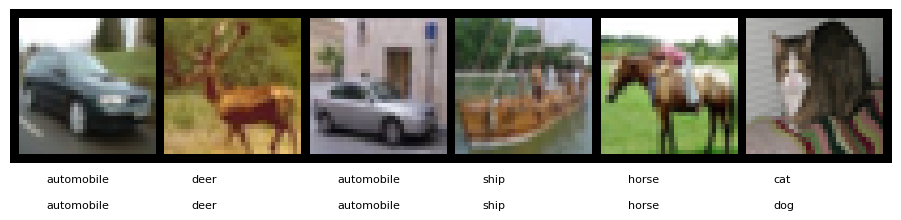

In [8]:
batch_size = 6
pred_iter = data.DataLoader(testset, batch_size, shuffle=True)
# 获取一个批次的数据
images, labels = next(iter(pred_iter))
trues = labels
preds = net(images).argmax(axis=1)
# 将Tensor转为网格并显示
grid = make_grid(images)  # 合并为网格图像
grid = grid.permute(1, 2, 0)  # 从 [C, H, W] 转为 [H, W, C] 供matplotlib显示
# 显示图像网格
plt.figure(figsize=(12,2))
plt.imshow(grid)
plt.axis('off')
# 在每个子图下方添加标签
for num, (true, pred) in enumerate(zip(trues, preds)):
    plt.text((num%batch_size)*(images.shape[2]+2)+8, (num//batch_size+1)*(images.shape[3]+2)+batch_size, 
             f"{classes[true]}", color='black', fontsize=8)
    plt.text((num%batch_size)*(images.shape[2]+2)+8, (num//batch_size+1)*(images.shape[3]+2)+batch_size*2, 
             f"{classes[pred]}", color='black', fontsize=8)
plt.show()

## 保存模型、统计分类准确率

- 执行了一次保存和载入。

- 分别计算了各label的accuracy和总体testset上的accuracy。

In [9]:
torch.save(net, 'models/HW2_CNN.pth')  #保存模型

In [10]:
model = torch.load('models/HW2_CNN.pth', weights_only=False)  #重新加载模型，验证模型保存是否成功
print(model)
model.eval()  # 切换到推理模式（关闭 Dropout/BatchNorm）
num_classes = len(classes)
metric = Accumulator(2*num_classes)  # 正确预测数、预测总数
batch_size = 100
test_iter = data.DataLoader(testset, batch_size, shuffle=False)
with torch.no_grad():
    for inputs, labels in test_iter:
        outputs = model(inputs)
        outputs_labels = outputs.argmax(axis=1)
        # 逐类统计
        for c in range(num_classes):
            mask = (outputs_labels == c)
            y_hat_c = outputs[mask]  # 筛选出类别c的预测
            y_c = labels[mask]       # 筛选出类别c的真实标签
            total = len(y_c)                  #计算该类别总个数
            correct = accuracy(y_hat_c, y_c)  #计算识别准确的个数
            metric.data[2*c] += correct  # 更新 correct
            metric.data[2*c+1] += total  # 更新 total

#输出各类别的识别准确率
correct, total = 0, 0
for c in range(num_classes):
    class_correct, class_total = metric[2*c], metric[2*c + 1]
    correct += class_correct
    total += class_total
    acc = 100 * class_correct / max(1, class_total)
    print(f"Class '{classes[c]}': {acc:.2f}%")
#输出全测试集上的识别准确率
acc = 100 * correct / total
print(f"Total: {acc:.2f}%")

Sequential(
  (0): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU()
  (10): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=1024, out_features=256, bias=True)
  (15): ReLU()
  (16): Dropout(p=0.3, inplace=False)
  (17): Linear(in_features=256, out_features=256, bias=True)
  (18): ReLU()
  (19): Dropout(p=0.3, inplace=False)
  (20): Linear(in_features=256,

根据得到的结果可以看出，动物的识别准确率明显低于交通工具，特别是猫猫的准确率非常低。

这可能是因为动物的类内差异大，而类间差异小。

- 比如猫的颜色、花纹、姿态、面部特征都可能与别的动物相近。
  
- 但是在猫这个类别本身的颜色、花纹、姿态、面部特征差异又比较大。

- 因此最好的解决方式是将所有的猫全都分到别的类中（地球猫猫教!）（不是！）

# 总结与反思

- 本次实验受到算力的限制，只能简单实现CNN功能，最终的识别准确率其实并不高。

- 参考了很多策略，本来试图使用resnet，但是本着尝试自己调参的心态，还是搭了比较简单的Alexnet。（话说直接调用torchvision里给的resnet不知道能拿到多少分）

- 还有就是一些图像预处理、数据增强、混合精度等方法都没使用，因为本质上是不断提高分类精度，感觉和这个实验本身也没有什么干系。

- 关于GPU加速的部分尝试了一些，但没成功，好像是因为显卡不支持CUDA的缘故。